In [35]:
import numpy as np
from scipy import linalg as LA
from scipy.linalg import eigvalsh
from scipy.sparse.linalg import eigsh
import scipy.sparse as sparse
import matplotlib.pyplot as plt
import matplotlib

In [36]:
eV_to_Ryd = 1 / 13.6
c = 3.80998 #hbar**2 / (2*m) in Angstrom^2 * eV

# pseudo-potential parameters for Aluminium
d = 0.350 # Angstroms
rc = 0.943 # Angstroms
U0 = -31.30 # Angstroms

In [37]:
#Potential
def U(K):
    Kn = LA.norm(K)
    if Kn > 0:
        return U0 * np.exp(-rc/d) * ( np.sin(rc*Kn) / (d*Kn * ( (d*Kn)**2 + 1 ) ) +  ( np.cos(Kn*rc) ) / ( (d*Kn)**2 + 1 ) )
    else:
        return U0 * np.exp(-rc/d) * (rc/d+1)

In [38]:
# Aluminium has a ffc lattice with a spacing of a = 4.05 Angstroms
a = 4.05 # Angstroms
(a1, a2, a3) = 0.5 * a * np.array( [ [1,1,0], [1,0,1], [0,1,1] ] )

# Calculate the reciprocal lattice vectors
b1 = 2 * np.pi * np.cross(a2, a3) / a1.dot( np.cross(a2, a3) )
b2 = 2 * np.pi * np.cross(a3, a1) / a2.dot( np.cross(a3, a1) )
b3 = 2 * np.pi * np.cross(a1, a2) / a3.dot( np.cross(a1, a2) )

In [39]:
# Suffle the index to make sure we have negative K
def l(ji, N):
    if ( ji+1 > (N+1)/2 ):
        return ji-N
    else:
        return ji

def generate_lattice(N):
    K = np.empty( [N,N,N], dtype=np.ndarray )
    r = np.empty( K.shape, dtype=np.ndarray )

    for i, j, k in np.ndindex((N,N,N) ):
        K[i,j,k] = l(i,N) * b1 + l(j,N) * b2 + l(k,N) * b3

    return K, r

def generate_potential(K):
    vector_U = np.vectorize(U)
    return vector_U(K)

def get_ek(K, k):
    q = K + k
    return c * q.dot(q)

vector_get_ek = np.vectorize( get_ek, excluded = [1] )

def get_H_block(k, K, U_K):
    eks = vector_get_ek(K, k)
    print(eks.shape)
    H = np.diagflat(eks)
    m, n = np.indices(H.shape)
    H += U_K.flat[np.abs(m-n)]
    return H

def efficient_new_H(H, k, K, U_K):
    np.fill_diagonal( H, vector_get_ek(K, k).flat + U_K[0,0,0] )
    return H

In [40]:
# High symmetry points for the reciprocal lattice
L       = 2 * np.pi / a * np.array( [1/2, 1/2, 1/2] )
gamma   = 2 * np.pi / a * np.array( [  0,   0,   0] )
X       = 2 * np.pi / a * np.array( [  0,   1,   0] )
pointU  = 2 * np.pi / a * np.array( [1/4,   1, 1/4] )

path = [L, gamma, X, pointU, gamma]
labels = ['L', r'$\Gamma$', 'X', 'U', r'$\Gamma$']

ksteps = 25
N = 12
bands = 6

In [41]:
energies = np.zeros([ ksteps * (len(path)-1), bands ])
kscale = np.zeros( ksteps * len(path)-1 )

In [42]:
K, r = generate_lattice(N)
U_K = generate_potential(K)

label_locations = []
H = get_H_block( np.array( [0.0, 0.0, 0.0] ), K, U_K  )


(12, 12, 12)


In [43]:
for i in range(0, len(path)-1):
    label_locations.append(i * ksteps)
    kstep = (path[i+1]-path[i]) / ksteps
    for step in range(ksteps):
        qval = path[i] + step*kstep
        H = efficient_new_H(H, qval, K, U_K)
        # print(H, "\n")
        H_sparse = sparse.csr_matrix(H)
        eigenvalues, _ = eigsh(H_sparse, k=bands, which='SM')
        energies[step+i*ksteps,:] = eigenvalues
        kscale[step+i*ksteps] = LA.norm(kstep)
        # print(f"Path: {i+1} of {len(path)-1},  Step: {step+1} of {ksteps}     ",end="\r")
print(f"Completed                                                     ")

Completed                                                     


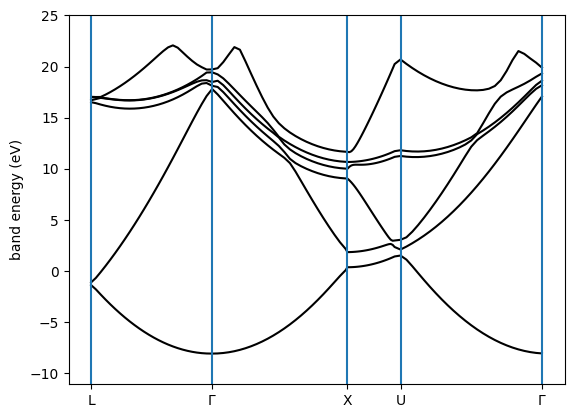

In [44]:
label_locations.append(step+i*ksteps)
kvals = np.cumsum(kscale)
font = {"family" : "serif", "weight" : "bold", "size" : 18}

for n in range(bands):
    plt.plot(kvals[:len(energies[:,n])], energies[:,n], c="black")

plt.vlines([kvals[x] for x in label_locations], energies.min()-5, energies.max()+5)
plt.ylim(energies.min()-3, energies.max()+3)
plt.ylabel("band energy (eV)")
plt.xticks([kvals[x] for x in label_locations], labels=labels)

plt.savefig("Al_bands.png", bbox_inches="tight")